# ECI 249 HW \#2

Kenneth Larrieu

Take $Q =$ flood flow, $q =$ levee design max flood flow.

We know the following:

Stage-discharge relation: $S(Q)$

Flood damage as a function of flood flow and levee design max flow: $D(Q, q)$

Annualized cost of levee construction as a function of levee design max flow: $C(q)$

The CDF of max annual flood flow frequency (Gumbel, EVI):

$$F(Q) = e^{-e^{-a(Q-b)}}$$

Thus, the pdf is:

$$f(Q) = a e^{-a(Q-b)} e^{-e^{-a(Q-b)}}$$

where $a = \frac{\pi}{\sqrt{6} \sigma}$, $b = \mu - \frac{0.5772}{a}$

## a. Estimate optimal levee height if built now and assuming the flood frequency parameters are known with certainty to be their average values.

In this case, we take $\mu = 60,000$ cfs, $\sigma = 21,000$ cfs.

The total expected value cost to minimize is then:

$$\text{EVC}(q) = \int_q^{\infty} D(Q, q) f(Q) dQ + C(q)$$

In [1]:
import numpy as np
import mpmath as mp
import matplotlib.pyplot as plt
%matplotlib inline

def damage(Q, q):
    '''Returns flood damage in USD.
    Q = flood flow (cfs)
    q = designed flood flow (cfs)
    '''
    if Q <= q or Q <= 60000:
        return 0
    else:
        d0 = 1000000 # damage per foot overbank, given Q > q
        sf = 0.005*(Q-60000)**0.7 # flood stage above bank (ft)
        d = d0*sf
        return d
        
def ccost(q):
    '''Returns construction cost (USD) to build levee protecting up to design flow q (cfs)'''
    if q <= 60000:
        return 0
    else:
        c0 = 10 # cost per cubic yard
        l = 2000 # length
        sl = 0.005*(q-60000)**0.7 # levee stage above bank (ft)
        sl = (sl+2.0)/3 # add freeboard and convert to yards
        xs = (16.0/3)*sl + 3*((sl)**2) # cross-section area
        r = 0.05 # annualize cost
        c = c0*l*xs*r
        return c
    
def gumbel_pdf(Q, mu=60000, sigma=21000):
    '''Gumbel pdf for flood of size Q. If no assigned mu and sigma, defaults to average.'''
    a = np.pi/(np.sqrt(6)*sigma)
    b = mu - 0.5772/a
    f = a * (np.e**(-np.e**(-a*(Q-b)))) * np.e**(-a*(Q-b))
    return f

# Calculate expected value of cost for given design flow
def evd_perf(q, mu=60000, sigma=21000):
    '''Returns expected value of damage for levee height q'''
    integrand = lambda Q: damage(Q, q)*gumbel_pdf(Q, mu=mu, sigma=sigma)
    if q < 60000:
        expected_damage = mp.quad(integrand, [60000, np.inf])
    else:
        expected_damage = mp.quad(integrand, [q, np.inf])
    return expected_damage

def evc_perf(q, mu=60000, sigma=21000):
    return float(evd_perf(q, mu=mu, sigma=sigma) + ccost(q))

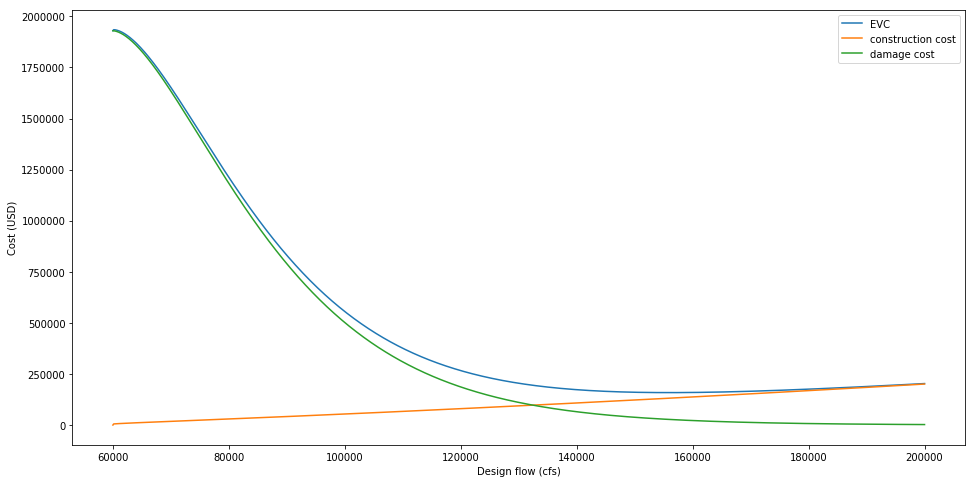

In [2]:
# plot the EVC
fig, ax = plt.subplots(figsize=(16, 8))
qs = np.linspace(60000, 200000, 1001)
d_costs = [evd_perf(q) for q in qs]
ccosts = [ccost(q) for q in qs]
total_costs = [d + c for d, c in list(zip(d_costs, ccosts))]
ax.plot(qs, total_costs, label = 'EVC')
ax.plot(qs, ccosts, label='construction cost')
ax.plot(qs, d_costs, label='damage cost')
ax.set_xlabel('Design flow (cfs)')
ax.set_ylabel('Cost (USD)')
ax.legend()
plt.show()

From the plot, we see that the optimal design flow is somewhere between $140,000$ and $180,000$ cfs. Minimizing the EVC function to find this value, and the corresponding optimal levee height:

In [3]:
from scipy.optimize import minimize_scalar

def min_evc_perf(mu=60000, sigma=21000):
    output = minimize_scalar(lambda q: evc_perf(q, mu=mu, sigma=sigma),
                             bounds=[60e3, 10e8], method='bounded')
    return output.x

best_q = min_evc_perf()
print('optimal q = %.2f cfs' % best_q)
# convert design flow to a levee design height
h = 0.005*(best_q-60000)**0.7
print('optimal height = %.2f ft' % h)

optimal q = 155988.03 cfs
optimal height = 15.36 ft


Thus, with perfect knowledge of parameters, the optimal levee height is $\boxed{15.36 \text{ ft.}}$

## b. Estimate the optimal height of the levee for this case, if it is built now but assuming the flood frequency parameters are known only in terms of their probability distributions.

Since the parameters $\mu_Q$ and $\sigma_Q$ are independently distributed, the joint distribution becomes:

$$f(Q, \mu_Q, \sigma_Q) = f_{Q, \mu_Q, \sigma_Q}(Q, \mu_Q, \sigma_Q) = f_{Q | \mu_Q, \sigma_Q}(Q | \mu_Q, \sigma_Q) \cdot f_{\mu_Q}(\mu_Q) \cdot f_{\sigma_Q}(\sigma_Q)$$

Where the distributions of $\mu_Q$ and $\sigma_Q$ are the following:

$$f_{\mu_Q}(\mu_Q) = \frac{1}{\sqrt{2 \pi} \sigma_{\mu}} e^{- \frac{(\mu_Q - \mu_{\mu})^2}{2 \sigma_{\mu}^2}}$$

$$f_{\sigma_Q}(\sigma_Q) = \frac{1}{\sqrt{2 \pi} \sigma_{\sigma}} e^{- \frac{(\mu_Q - \mu_{\sigma})^2}{2 \sigma_{\sigma}^2}}$$

The expression for expected value of cost becomes:

$$\text{EVC}(q) = \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} \int_q^{\infty} D(Q, q) f(Q, \mu_Q, \sigma_Q) dQ d\mu_Q d\sigma_Q + C(q)$$

In [4]:
def mean_pdf(mu):
    mu_mu = 60000
    sigma_mu = 21000/(np.sqrt(40)) # from central limit theorem, 40 years of samples
    return 1.0/(np.sqrt(2*np.pi)*sigma_mu) * np.e**(-((mu-mu_mu)**2)/(2*sigma_mu**2))
    
def std_pdf(sigma):
    mu_sigma = 21000
    sigma_sigma = 7000
    return 1.0/(np.sqrt(2*np.pi)*sigma_sigma) * np.e**(-((sigma-mu_sigma)**2)/
                                                       (2*sigma_sigma**2))

def evd(q):
    integrand = lambda Q, mu, sigma: damage(Q, q)*gumbel_pdf(Q, mu=mu, sigma=sigma)*
                                     mean_pdf(mu)*std_pdf(sigma)
    integral = mp.quad(integrand, [q, 300000], [50000, 70000], [1000, 40000])
    return integral

def evc(q):
    return evd(q) + ccost(q)

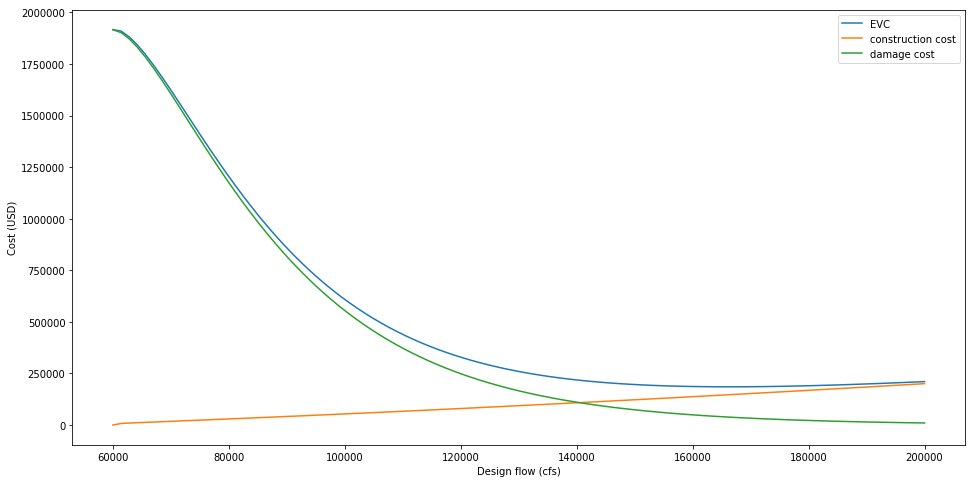

In [5]:
# plot the EVC estimates
fig, ax = plt.subplots(figsize=(16, 8))
qs = np.linspace(60000, 200000, 101)
d_costs = [evd(q) for q in qs]
ccosts = [ccost(q) for q in qs]
total_costs = [d + c for d, c in list(zip(d_costs, ccosts))]
ax.plot(qs, total_costs, label = 'EVC')
ax.plot(qs, ccosts, label='construction cost')
ax.plot(qs, d_costs, label='damage cost')
ax.set_xlabel('Design flow (cfs)')
ax.set_ylabel('Cost (USD)')
ax.legend()
plt.show()

The optimal design flow appears to be somewhere between $100,000-200,000$ cfs. Again, we can find the optimal design flow by minimizing $EVC(q)$:

In [6]:
result = minimize_scalar(lambda q: evc(q), bounds=[1e5, 2e5], method='bounded')
best_q = float(result.x)
print('optimal q = %.2f cfs' % best_q)
# convert design flow to a levee design height
h = 0.005*(best_q-60000)**0.7
print('optimal height = %.2f ft' % h)

optimal q = 166341.52 cfs
optimal height = 16.51 ft


Thus, the optimal levee height with the given uncertainties is $\boxed{\text{16.51 ft}.}$

## c. Is it worthwhile to wait for additional data before building the levee? What are some of the weaknesses of this methodology? In what ways might it be extended?



The expected loss of constructing for design flood $q^*$ due imperfect knowledge of parameters $\underline{\theta}$ is:

$$XL(q^* | f(\underline{\theta})) = \int \int \{EVC(q^*|\underline{\theta}) - EVC(q_T(\underline{\theta})|\underline{\theta})\} f(\underline{\theta}) d\theta_1 d\theta_2$$

Where $q_T(\underline{\theta})$, the true design flow, is just the EVC when we have perfect knowledge of $\underline{\theta}$, as in part a. 

Waiting a year to get a new peak flood flow observation $Q_N$ allows updating of $f(\underline{\theta})$ using Bayes' theorem:

$$f(\underline{\theta} | Q_N) = \frac{f(\underline{\theta}) P(Q_N | \underline{\theta})}{P(Q_N)}$$

The expected benefit of waiting a year is then the difference between expected loss before and after the observation of $Q_N$:

$$EVBQ_N = XL(q^* | f(\underline{\theta})) - \int_{0}^{\infty} XL(q^* | f(\underline{\theta} | Q_N)) f(\underline{\theta} | Q_N) dQ_N$$

The expected cost of waiting a year is the damage expected with no levee, minus the annualized cost avoided by waiting to build:

$$EVCQ_N = \int_{0}^{\infty} D(Q_N) P(Q_N) dQ_N - C(q^*)$$

Comparing the expected cost and benefit of waiting a year will determine whether it is worthwhile to wait.

In [7]:
def int_2d(integrand, lims1, lims2, bins=100):
    '''integrates first arg across lims1 and second arg across lims2'''
    integral = 0
    xs = np.linspace(lims1[0], lims1[1], bins+1)
    xs = map(np.mean, zip(xs, xs[1:]))
    ys = np.linspace(lims2[0], lims2[1], bins+1)
    ys = map(np.mean, zip(ys, ys[1:]))
    dx = xs[1] - xs[0]
    dy = ys[1] - ys[0]
    
    for x in xs:
        # print('%i %%' % xs.index(x))
        for y in ys:
            integral += integrand(x, y) * dx * dy
            
    return integral

def int_1d(integrand, lims, bins=100):
    
    integral = 0
    xs = np.linspace(lims[0], lims[1])

In [8]:
q_star = 166341 # optimal design flow now given uncertainties (part b)

# calculating evb_qn

def evc_given_params(q, mu, sigma):
    '''Returns EVC of design q given perfect knowledge of mu and sigma'''
    integrand = lambda Q: damage(Q, q)*gumbel_pdf(Q, mu=mu, sigma=sigma)
    expected_damage = mp.quad(integrand, [q, np.inf])
    return expected_damage + ccost(q)

q_T = min_evc_perf

def xl(param_pdf):
    '''Expected loss from design q_star, with param_pdf'''
    integrand = lambda mu, sigma: (evc_given_params(q_star, mu, sigma) - 
                                   evc_given_params(q_T(mu, sigma), mu, sigma)) * 
                                   param_pdf(mu, sigma)
    integral = int_2d(integrand, [50000, 70000], [1000, 40000])
    return integral

def f_given_qn(mu, sigma, Qn):
    numerator = mean_pdf(mu) * std_pdf(sigma) * gumbel_pdf(Qn, mu=mu, sigma=sigma)
    den_integrand = lambda mu_var, sigma_var: gumbel_pdf(Qn, mu=mu_var, sigma=sigma_var)*
                                              mean_pdf(mu_var)*std_pdf(sigma_var)
    denominator = int_2d(den_integrand, [50000, 70000], [1000, 40000])
    return numerator * 1.0/denominator

def xl_given_qn(qn):
    return xl(lambda mu, sigma: f_given_qn(mu, sigma, qn))

xl_no_wait = xl(lambda mu, sigma: mean_pdf(mu) * std_pdf(sigma))

# integrand = xl_given_qn
# xl_wait = mp.quad(integrand, [0, np.inf])
# evb_qn = xl_no_wait - xl_wait

In [9]:
# calculating evc_qn

integrand = lambda Q: damage(Q, q=60000) * gumbel_pdf(Q)
cost_no_levee = mp.quad(integrand, [60000, np.inf])
annualized_cost = ccost(q_star)

evc_qn = cost_no_levee - annualized_cost

print('XL no wait: %.2f' % xl_no_wait)
print('EVC waiting one year: %.2f' % evc_qn)

XL no wait: 26033.82
EVC waiting one year: 1782640.96


Because $EVBQ_N < XL(q^* | f(\underline{\theta}))$ and we have just shown that $XL(q^* | f(\underline{\theta})) < EVCQ_N$, we can concldue that $EVBQ_N < EVCQ_N$. Therefore, $\boxed{\text{it is not worth waiting an additional year.}}$

Weaknesses and extensions:

This method accounts for uncertainties in the parameters of the flood frequency distribution, but it assumes the form of the distribution as EV Type I. In addition, the model does not account for uncertainties in the functions for construction costs and damages incurred for a given flood.

An extension might also consider physical mechanisms of levee failure other than overtopping. The problem could also be framed as a multi-stage problem where levee heights may be incrementally extended, and solved with a stochastic dynamic program.